# Prédiction des Crimes Violents par Habitant

## Introduction

Ce notebook Jupyter est une composante essentielle du projet de **Prédiction du nombre de crimes violents par habitant**. Il détaille l'ensemble du processus, de la préparation des données brutes à la construction, l'évaluation et la comparaison de plusieurs modèles de régression.

Le code et les analyses présentés ici ont été conçus pour être clairs, reproductibles et réutilisables, notamment dans le cadre d'une future application interactive (via Streamlit).

## Objectif de ce Notebook

L'objectif principal de ce notebook est de démontrer et d'exécuter les étapes suivantes :

1.  **Chargement et Manipulation Initiale des Données :** Intégrer les données socio-économiques (CENSUS 1990) et criminelles (FBI UCR 1995) issues de l'archive UCI Machine Learning.
2.  **Nettoyage et Ingénierie des Caractéristiques :** Gérer les valeurs manquantes et sélectionner les variables les plus pertinentes via une analyse de corrélation.
3.  **Construction et Évaluation de Plusieurs Modèles Prédictifs :** Entraîner et évaluer différents algorithmes de régression pour identifier le plus performant.
4.  **Optimisation et Sélection du Meilleur Modèle :** Affiner les hyperparamètres du modèle choisi et le préparer pour une utilisation future (par exemple, exportation pour une application).

## Structure du Notebook

Le notebook est organisé en sections claires pour une navigation facile :

* **1. Configuration de l'Environnement et Chargement des Données**
* **2. Nettoyage et Préparation des Données**
* **3. Sélection des Caractéristiques**
* **4. Modélisation et Comparaison de Modèles**
* **5. Évaluation Détaillée et Sélection Finale du Modèle**
* **6. Optimisation Avancée et Exportation du Modèle**

## Prérequis

Pour exécuter ce notebook, assurez-vous que les bibliothèques Python suivantes sont installées dans votre environnement :

* `pandas`
* `numpy`
* `matplotlib`
* `seaborn`
* `scikit-learn`
* `joblib` (sera utilisé pour l'exportation du modèle)

Vous pouvez les installer via pip, de préférence en utilisant un fichier `requirements.txt` (que nous créerons ou mettrons à jour) :

```bash
pip install -r requirements.txt

# 1. Configuration de l'Environnement et Chargement des Données

Cette section est dédiée à la mise en place de l'environnement Python nécessaire, à l'importation des bibliothèques clés et au chargement des données brutes du projet. Nous nous assurons que toutes les dépendances sont déclarées et que les fichiers de données sont correctement importés.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score as r2
import joblib # Pour l'exportation et le chargement du modèle

# --- Configuration du chemin des données ---
# Assurez-vous que les fichiers 'communities.data' et 'communities.names'
# sont bien placés dans le dossier 'data/' de votre projet.
# Le chemin est relatif si ce notebook est exécuté depuis 'notebook/'.
data_path = '../data/'

# --- 1.2. Extraction des noms de colonnes à partir de 'communities.names' ---
# Le fichier 'communities.names' contient les métadonnées et la liste des attributs
# sous le format ARFF (e.g., '@attribute attribute_name numeric').
# Nous devons parser ce fichier pour extraire uniquement les noms des colonnes.

column_names = []
with open(data_path + 'communities.names', 'r') as f:
    for line in f:
        if line.startswith('@attribute'):
            # Extrait le nom de l'attribut (après '@attribute' et avant le type ou espace)
            parts = line.split()
            if len(parts) > 1:
                col_name = parts[1]
                # Gérer le cas des noms de colonnes contenant des chaînes (e.g., 'communityname string')
                # Enlève le type si c'est 'numeric' ou 'string'
                if col_name.lower() not in ['numeric', 'string', 'real', 'integer']:
                     # Si le nom de colonne contient un apostrophe (pour des noms comme 'ViolentCrimesPerPop')
                    if "'" in col_name:
                        col_name = col_name.replace("'", "")
                    column_names.append(col_name)

# Correction manuelle pour s'assurer que 'ViolentCrimesPerPop' est bien inclus si le parsing initial le manquait,
# ou si d'autres noms spécifiques nécessitent une attention particulière
# Le parsing ci-dessus devrait inclure 'ViolentCrimesPerPop'.
# Si des noms manquaient, on pourrait les ajouter ici, par exemple:
# if 'ViolentCrimesPerPop' not in column_names:
#     column_names.append('ViolentCrimesPerPop')


# --- 1.3. Chargement du jeu de données principal ---
# Les valeurs '?' sont spécifiées comme des valeurs manquantes (NaN) lors du chargement.
data = pd.read_csv(data_path + 'communities.data', names=column_names, na_values=["?"])


print("Chargement des données terminé.")
print("Aperçu des premières lignes du jeu de données :")
print(data.head())
print(f"\nDimensions du jeu de données initial: {data.shape}")
print(f"Noms des colonnes extraits: {data.columns.tolist()}")

Chargement des données terminé.
Aperçu des premières lignes du jeu de données :
   state  county  community        communityname  fold  population  \
0      8     NaN        NaN         Lakewoodcity     1        0.19   
1     53     NaN        NaN          Tukwilacity     1        0.00   
2     24     NaN        NaN         Aberdeentown     1        0.00   
3     34     5.0    81440.0  Willingborotownship     1        0.04   
4     42    95.0     6096.0    Bethlehemtownship     1        0.01   

   householdsize  racepctblack  racePctWhite  racePctAsian  ...  LandArea  \
0           0.33          0.02          0.90          0.12  ...      0.12   
1           0.16          0.12          0.74          0.45  ...      0.02   
2           0.42          0.49          0.56          0.17  ...      0.01   
3           0.77          1.00          0.08          0.12  ...      0.02   
4           0.55          0.02          0.95          0.09  ...      0.04   

   PopDens  PctUsePubTrans  PolicCar

# 2. Nettoyage et Préparation des Données

Cette étape est cruciale pour assurer la qualité et l'exploitabilité de votre jeu de données. Elle comprend la suppression des colonnes non pertinentes et la gestion des valeurs manquantes, des actions essentielles pour un modèle de Machine Learning fiable.

## 2.1. Suppression des Attributs Non Prédictibles

Comme indiqué dans la documentation des attributs `attributs.names`, certaines colonnes ne sont pas destinées à être des prédicteurs ou sont de nature catégorique/identifiante. Il s'agit de :
* `state`, `county`, `community` : codes numériques pour l'état, le comté et la communauté, non considérés comme prédictifs et souvent avec des valeurs manquantes.
* `communityname` : nom de la communauté, utilisé uniquement à titre d'information et non prédictif.
* `fold` : numéro de fold pour la validation croisée, utile pour le débogage mais non prédictif.

La suppression de ces colonnes simplifie le jeu de données et concentre l'analyse sur les variables directement exploitables par notre modèle de régression.

In [7]:
# Colonnes à supprimer car non prédictibles ou catégoriques
columns_to_drop_initial = ['state', 'county', 'community', 'communityname', 'fold']

# Vérifier si les colonnes existent avant de les supprimer pour éviter les erreurs
existing_columns_to_drop = [col for col in columns_to_drop_initial if col in data.columns]

if existing_columns_to_drop:
    initial_shape = data.shape
    data = data.drop(columns=existing_columns_to_drop, axis=1)
    print(f"Colonnes supprimées: {existing_columns_to_drop}")
    print(f"Dimensions du jeu de données après cette étape: {data.shape}")
    print("Aperçu des premières lignes après suppression des colonnes initiales:")
    print(data.head())
else:
    print("Aucune des colonnes initiales à supprimer n'a été trouvée dans le DataFrame.")
    print(f"Dimensions actuelles du jeu de données: {data.shape}")

Colonnes supprimées: ['state', 'county', 'community', 'communityname', 'fold']
Dimensions du jeu de données après cette étape: (1994, 123)
Aperçu des premières lignes après suppression des colonnes initiales:
   population  householdsize  racepctblack  racePctWhite  racePctAsian  \
0        0.19           0.33          0.02          0.90          0.12   
1        0.00           0.16          0.12          0.74          0.45   
2        0.00           0.42          0.49          0.56          0.17   
3        0.04           0.77          1.00          0.08          0.12   
4        0.01           0.55          0.02          0.95          0.09   

   racePctHisp  agePct12t21  agePct12t29  agePct16t24  agePct65up  ...  \
0         0.17         0.34         0.47         0.29        0.32  ...   
1         0.07         0.26         0.59         0.35        0.27  ...   
2         0.04         0.39         0.47         0.28        0.32  ...   
3         0.10         0.51         0.50         0

## 2.2. Gestion des Valeurs Manquantes

La présence de valeurs manquantes peut nuire à la performance des modèles. Nous allons les identifier et les traiter de manière appropriée.

Le fichier `communities.names` mentionne spécifiquement que "Many communities are missing LEMAS data". [cite_start]Les attributs liés à LEMAS sont listés plus bas dans la documentation et plusieurs d'entre eux ont un grand nombre de valeurs manquantes (par exemple, 1675 sur 1994 instances pour `LemasSwornFT`, `LemasSwFTPerPop`, etc.).

Nous adoptons la stratégie suivante :
* **Imputation pour `OtherPerCap` :** Cette colonne a une seule valeur manquante. Étant donné son faible nombre, une imputation par la moyenne de la colonne est une approche simple et efficace.
* **Suppression des colonnes avec trop de valeurs manquantes :** Pour les colonnes où la proportion de valeurs manquantes est très élevée (plus de 50%, comme c'est le cas pour la plupart des attributs LEMAS), il est préférable de les supprimer. L'imputation pour un grand nombre de valeurs manquantes pourrait introduire un biais significatif et réduire la qualité des données.

In [9]:
# Identifier les colonnes avec des valeurs manquantes
feat_miss = data.columns[data.isnull().any()]

if len(feat_miss) > 0:
    print(f"\nColonnes avec des valeurs manquantes avant traitement: {list(feat_miss)}")
    print("Pourcentage de valeurs manquantes par colonne:")
    missing_percentages = data[feat_miss].isnull().sum() * 100 / len(data)
    print(missing_percentages.sort_values(ascending=False))

    # Imputation de 'OtherPerCap' par la moyenne
    if 'OtherPerCap' in feat_miss:
        initial_missing_count_opc = data['OtherPerCap'].isnull().sum()
        data['OtherPerCap'] = data['OtherPerCap'].fillna(data['OtherPerCap'].mean())
        print(f"\nValeurs manquantes dans 'OtherPerCap' imputées par la moyenne (initial: {initial_missing_count_opc}).")
        # Retirer OtherPerCap de la liste des colonnes manquantes si elle a été traitée
        feat_miss = data.columns[data.isnull().any()] # Mettre à jour la liste après imputation

    # Supprimer les colonnes avec plus de 50% de valeurs manquantes
    cols_to_drop_due_to_missing_high_perc = [col for col in feat_miss if missing_percentages[col] > 50]

    if cols_to_drop_due_to_missing_high_perc:
        data_before_drop = data.shape
        data = data.drop(columns=cols_to_drop_due_to_missing_high_perc, axis=1)
        print(f"\nColonnes supprimées en raison de plus de 50% de valeurs manquantes: {cols_to_drop_due_to_missing_high_perc}")
        print(f"Dimensions du jeu de données après cette étape: {data.shape}")
    else:
        print("\nPas de colonnes avec plus de 50% de valeurs manquantes à supprimer (hors 'OtherPerCap' déjà traitée).")

    # Vérification finale: s'il reste des NaN après ces traitements, dropna sur les lignes restantes
    # (cela ne devrait pas arriver si le traitement des colonnes est exhaustif)
    if data.isnull().sum().sum() > 0:
        initial_rows_with_nan = data.shape[0]
        data.dropna(inplace=True)
        print(f"\nLignes avec des valeurs manquantes restantes supprimées. Lignes avant: {initial_rows_with_nan}, Lignes après: {data.shape[0]}")

else:
    print("\nAucune valeur manquante trouvée dans le jeu de données après la suppression initiale des colonnes.")


print("\n--- Récapitulatif du Nettoyage des Données ---")
print(f"Dimensions finales du jeu de données après nettoyage: {data.shape}")
print("Nombre total de valeurs manquantes après nettoyage (devrait être 0):")
print(data.isnull().sum().sum())
print("\nAperçu du jeu de données après toutes les étapes de nettoyage :")
print(data.head())


Aucune valeur manquante trouvée dans le jeu de données après la suppression initiale des colonnes.

--- Récapitulatif du Nettoyage des Données ---
Dimensions finales du jeu de données après nettoyage: (1994, 101)
Nombre total de valeurs manquantes après nettoyage (devrait être 0):
0

Aperçu du jeu de données après toutes les étapes de nettoyage :
   population  householdsize  racepctblack  racePctWhite  racePctAsian  \
0        0.19           0.33          0.02          0.90          0.12   
1        0.00           0.16          0.12          0.74          0.45   
2        0.00           0.42          0.49          0.56          0.17   
3        0.04           0.77          1.00          0.08          0.12   
4        0.01           0.55          0.02          0.95          0.09   

   racePctHisp  agePct12t21  agePct12t29  agePct16t24  agePct65up  ...  \
0         0.17         0.34         0.47         0.29        0.32  ...   
1         0.07         0.26         0.59         0.35    

# 3. Sélection des Caractéristiques

Pour construire un modèle de prédiction performant et interprétable, il est souvent bénéfique de sélectionner les caractéristiques les plus pertinentes. Une méthode courante consiste à analyser la corrélation des variables explicatives avec la variable cible.

## 3.1. Analyse de Corrélation et Visualisation

Nous allons d'abord calculer la matrice de corrélation de Pearson pour toutes les variables du jeu de données. La visualisation de cette matrice sous forme de heatmap nous donnera un aperçu rapide des relations linéaires entre les variables. Une attention particulière sera portée aux corrélations avec notre variable cible, `ViolentCrimesPerPop`.

Matrice de corrélation calculée. Aperçu :
               population  householdsize  racepctblack  racePctWhite  \
population          1.000          0.046         0.231         0.301   
householdsize       0.046          1.000         0.067         0.236   
racepctblack        0.231          0.067         1.000         0.794   
racePctWhite        0.301          0.236         0.794         1.000   
racePctAsian        0.182          0.202         0.107         0.270   

               racePctAsian  racePctHisp  agePct12t21  agePct12t29  \
population            0.182        0.156        0.006        0.130   
householdsize         0.202        0.469        0.520        0.367   
racepctblack          0.107        0.067        0.122        0.153   
racePctWhite          0.270        0.444        0.194        0.267   
racePctAsian          1.000        0.267        0.025        0.101   

               agePct16t24  agePct65up  ...  PctForeignBorn  PctBornSameState  \
population           0.

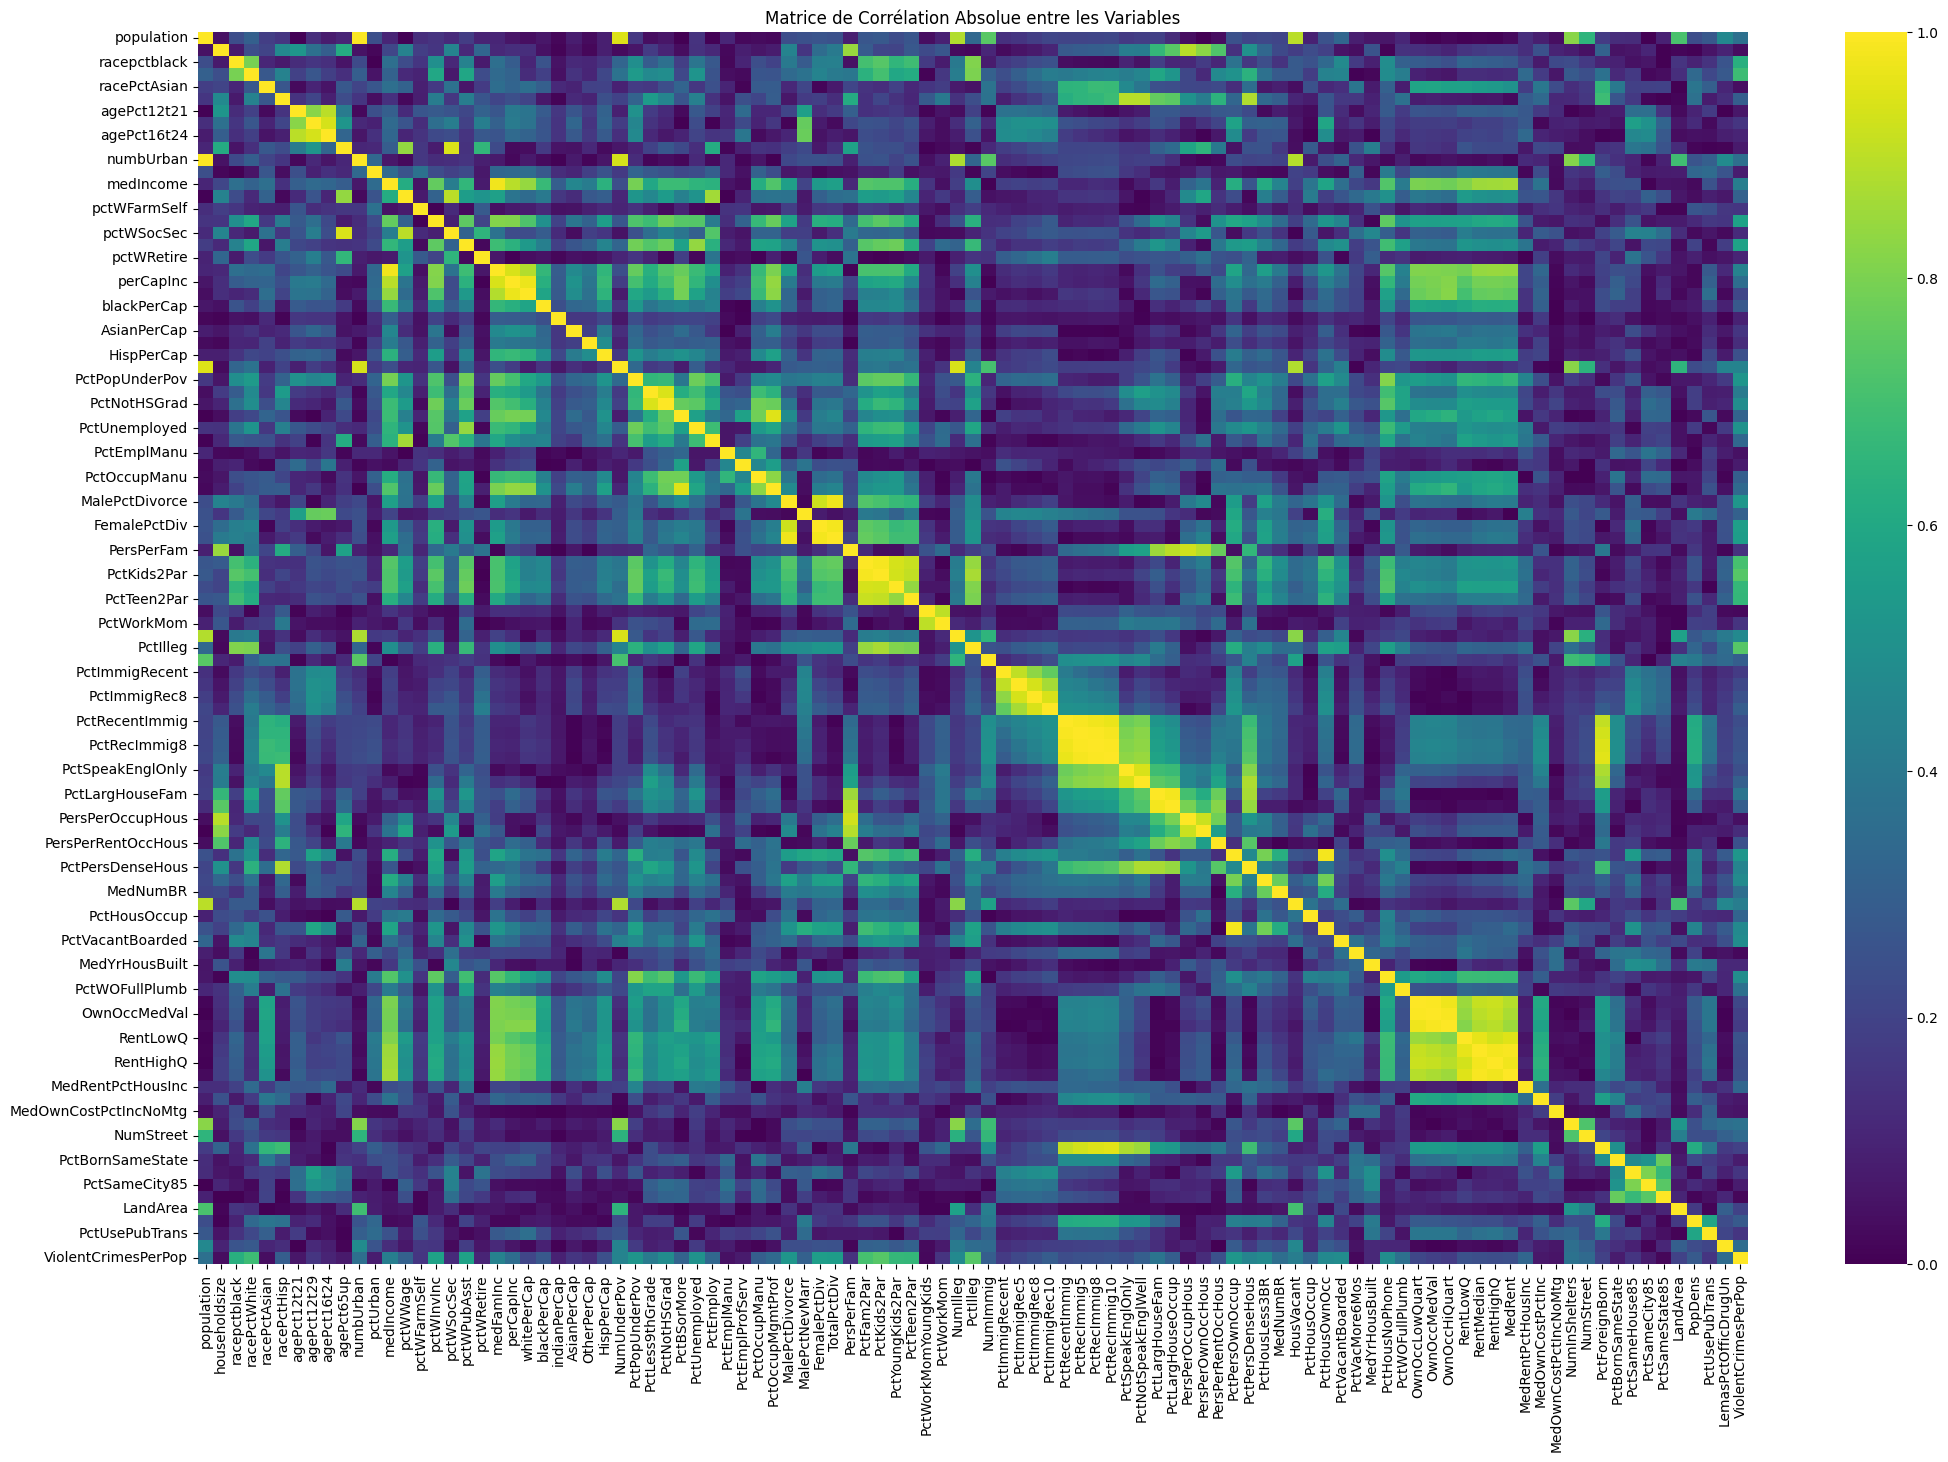


La heatmap ci-dessus visualise les corrélations absolues entre toutes les paires de variables.
Des couleurs plus intenses (proches de 1) indiquent une corrélation plus forte.


In [10]:
# Calcul de la matrice de corrélation de Pearson
# Nous utilisons .abs() pour obtenir les valeurs absolues des corrélations,
# car nous sommes intéressés par la force de la relation, qu'elle soit positive ou négative.
corr_matrix = data.corr(method='pearson').round(3).abs()

print("Matrice de corrélation calculée. Aperçu :")
print(corr_matrix.head())

# Visualisation de la matrice de corrélation avec une heatmap
plt.figure(figsize=(25, 16)) # Ajustez la taille pour une meilleure lisibilité si nécessaire
sns.heatmap(corr_matrix, cmap='viridis') # 'viridis' ou 'coolwarm' sont de bonnes options
plt.title('Matrice de Corrélation Absolue entre les Variables')
plt.show()

print("\nLa heatmap ci-dessus visualise les corrélations absolues entre toutes les paires de variables.")
print("Des couleurs plus intenses (proches de 1) indiquent une corrélation plus forte.")

## 3.2. Sélection des Caractéristiques Basée sur la Corrélation

Pour un modèle de régression, l'objectif est d'identifier les variables explicatives qui ont la relation linéaire la plus forte avec la variable cible. Une corrélation de Pearson élevée (en valeur absolue) indique que deux variables tendent à varier ensemble de manière significative.

Le choix d'un seuil de corrélation de **0.40** est une décision heuristique visant à :
* **Réduire la dimensionalité :** En ne conservant que les variables ayant une relation linéaire "modérée à forte" avec le nombre de crimes violents par habitant, nous diminuons le nombre de prédicteurs. Cela réduit la complexité du modèle, le rendant potentiellement plus rapide à entraîner et moins sujet au surapprentissage.
* **Améliorer l'interprétabilité :** Un modèle basé sur un ensemble réduit de caractéristiques plus influentes est généralement plus facile à comprendre et à expliquer.
* **Diminuer le bruit :** Les variables faiblement corrélées apportent souvent peu d'informations utiles et peuvent même introduire du "bruit" dans le modèle, rendant la tâche d'apprentissage plus difficile.

Nous allons identifier ces variables et créer un nouveau DataFrame contenant uniquement ces caractéristiques sélectionnées, ainsi que la variable cible (`ViolentCrimesPerPop`).

In [11]:
# Définir le seuil de corrélation
correlation_threshold = 0.40
target_variable = 'ViolentCrimesPerPop'

# Identifier les variables corrélées à plus de 'correlation_threshold' avec la variable cible
# On utilise la matrice de corrélation calculée précédemment (corr_matrix)
# On sélectionne les corrélations avec la variable cible, puis on filtre par le seuil
highly_correlated_features = corr_matrix[target_variable][corr_matrix[target_variable] > correlation_threshold].index.tolist()

# Exclure la variable cible de la liste des caractéristiques si elle s'y est retrouvée (elle aura une corrélation de 1.0)
# pour la construction de X (variables explicatives)
features_for_X = [feature for feature in highly_correlated_features if feature != target_variable]

# Créer le DataFrame final avec les caractéristiques sélectionnées et la variable cible
data_final = data[features_for_X + [target_variable]].copy()

print(f"Seuil de corrélation utilisé : {correlation_threshold}")
print(f"Variable cible : {target_variable}")
print(f"\nNombre de variables explicatives sélectionnées : {len(features_for_X)}")
print("Liste des variables explicatives sélectionnées :")
print(features_for_X)

print(f"\nDimensions finales du jeu de données après sélection des caractéristiques : {data_final.shape}")
print("Aperçu du jeu de données final :")
print(data_final.head())

Seuil de corrélation utilisé : 0.4
Variable cible : ViolentCrimesPerPop

Nombre de variables explicatives sélectionnées : 27
Liste des variables explicatives sélectionnées :
['racepctblack', 'racePctWhite', 'medIncome', 'pctWInvInc', 'pctWPubAsst', 'medFamInc', 'NumUnderPov', 'PctPopUnderPov', 'PctLess9thGrade', 'PctNotHSGrad', 'PctUnemployed', 'MalePctDivorce', 'FemalePctDiv', 'TotalPctDiv', 'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'NumIlleg', 'PctIlleg', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'HousVacant', 'PctHousOwnOcc', 'PctVacantBoarded', 'PctHousNoPhone']

Dimensions finales du jeu de données après sélection des caractéristiques : (1994, 28)
Aperçu du jeu de données final :
   racepctblack  racePctWhite  medIncome  pctWInvInc  pctWPubAsst  medFamInc  \
0          0.02          0.90       0.37        0.60         0.15       0.39   
1          0.12          0.74       0.31        0.45         0.29       0.29   
2          0.49          0.56

# 4. Modélisation et Comparaison de Modèles

Après avoir préparé et sélectionné nos caractéristiques, l'étape suivante consiste à entraîner des modèles de Machine Learning capables de prédire le nombre de crimes violents par habitant. Un aspect crucial de ce processus est de ne pas se limiter à un seul algorithme, mais d'en comparer plusieurs pour identifier celui qui offre les meilleures performances et la meilleure adéquation avec nos données.

Cette section sera divisée en plusieurs sous-sections :
* **4.1. Division des Données et Normalisation :** Préparation des ensembles d'entraînement et de test, et standardisation des caractéristiques.
* **4.2. Entraînement et Évaluation du Modèle de Référence (Random Forest Regressor) :** Mise en place de notre premier modèle.
* **4.3. Comparaison avec d'Autres Modèles de Régression :** Introduction et évaluation d'autres algorithmes.

## 4.1. Division des Données et Normalisation

Avant d'entraîner tout modèle, nous devons diviser notre jeu de données en deux parties : un ensemble d'entraînement (`X_train`, `y_train`) pour que le modèle apprenne, et un ensemble de test (`X_test`, `y_test`) pour évaluer ses performances sur des données qu'il n'a jamais vues. Il est courant d'utiliser un ratio 75/25 pour l'entraînement/test.

De plus, la normalisation des caractéristiques (`X`) est une étape importante. La plupart des algorithmes de Machine Learning sont sensibles à l'échelle des données. La `StandardScaler` centre les données autour de zéro (moyenne = 0) et les met à l'échelle pour avoir une variance unitaire (écart-type = 1). Cela aide à prévenir que les caractéristiques avec des échelles plus grandes ne dominent pas l'apprentissage du modèle.

In [12]:
# --- 4.1.1. Définition des variables explicatives (X) et de la variable cible (y) ---
# X contient toutes les colonnes du DataFrame final sauf la variable cible
X = data_final.drop(columns=[target_variable]).values
# y est la variable cible
y = data_final[target_variable].values

print(f"Dimensions de X (variables explicatives): {X.shape}")
print(f"Dimensions de y (variable cible): {y.shape}")

# --- 4.1.2. Division du jeu de données en ensembles d'entraînement et de test ---
# test_size=0.25 signifie que 25% des données seront utilisées pour le test.
# random_state=42 assure la reproductibilité de la division pour les comparaisons.
seed = 42 # Utilisation d'une graine fixe pour la reproductibilité
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

print(f"\nDimensions de l'ensemble d'entraînement (X_train, y_train): {X_train.shape}, {y_train.shape}")
print(f"Dimensions de l'ensemble de test (X_test, y_test): {X_test.shape}, {y_test.shape}")

# --- 4.1.3. Normalisation des variables explicatives ---
# Création d'un objet StandardScaler
sc = StandardScaler()

# Appliquer la normalisation sur l'ensemble d'entraînement et de test
# fit_transform est utilisé sur l'entraînement pour apprendre les paramètres de normalisation
# transform est utilisé sur le test pour appliquer les mêmes paramètres appris sur l'entraînement
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

print("\nNormalisation des variables explicatives terminée.")
print("Aperçu de X_train_scaled (premières lignes, premières colonnes) :")
print(X_train_scaled[:5, :5]) # Afficher les 5 premières lignes et colonnes

Dimensions de X (variables explicatives): (1994, 27)
Dimensions de y (variable cible): (1994,)

Dimensions de l'ensemble d'entraînement (X_train, y_train): (1495, 27), (1495,)
Dimensions de l'ensemble de test (X_test, y_test): (499, 27), (499,)

Normalisation des variables explicatives terminée.
Aperçu de X_train_scaled (premières lignes, premières colonnes) :
[[-0.01446269  0.3302103  -1.14547543 -0.57515938  0.63436532]
 [-0.67794527  0.9839081  -0.12824348  1.05305054 -0.31279306]
 [ 0.57096311 -0.93632917 -0.95171696 -0.68744972  0.63436532]
 [-0.13154785  0.49363475  0.54991115  0.26701817 -0.58340974]
 [ 2.44432566 -1.75345141  1.17962617  0.99690537 -0.85402641]]


## 4.2. Entraînement et Évaluation du Modèle de Référence (Random Forest Regressor)

Le Random Forest Regressor est un algorithme d'apprentissage ensemble qui construit de multiples arbres de décision et fusionne leurs prédictions pour améliorer la précision et contrôler le surapprentissage. C'est un modèle robuste et performant, souvent utilisé comme bon point de départ (baseline) pour les problèmes de régression.

Nous allons entraîner ce modèle sur nos données normalisées (`X_train_scaled`, `y_train`) et évaluer ses performances initiales sur l'ensemble de test normalisé (`X_test_scaled`, `y_test`).

In [13]:
# --- 4.2.1. Construction et entraînement du modèle Random Forest Regressor ---
# n_estimators=100 signifie que le modèle construira 100 arbres de décision.
# random_state=seed assure la reproductibilité de l'entraînement du modèle.
rf_model = rfr(n_estimators=100, random_state=seed, n_jobs=-1) # n_jobs=-1 utilise tous les cœurs disponibles

# Entraînement du modèle
print("Entraînement du modèle Random Forest Regressor...")
rf_model.fit(X_train_scaled, y_train)
print("Modèle entraîné.")

# --- 4.2.2. Évaluation des performances sur l'ensemble de test ---
# Prédictions sur l'ensemble de test normalisé
y_pred_rf = rf_model.predict(X_test_scaled)

# Calcul du score R² (Coefficient de détermination)
r2_rf = r2(y_test, y_pred_rf)
print(f"\nScore R² du modèle Random Forest sur l'ensemble de test: {r2_rf:.4f}")

# Calcul de l'erreur absolue moyenne (MAE)
mae_rf = mae(y_test, y_pred_rf)
print(f"Erreur Absolue Moyenne (MAE) du modèle Random Forest: {mae_rf:.4f}")

# Calcul de l'erreur quadratique moyenne (MSE)
mse_rf = mse(y_test, y_pred_rf)
print(f"Erreur Quadratique Moyenne (MSE) du modèle Random Forest: {mse_rf:.4f}")

# --- 4.2.3. Évaluation par Validation Croisée ---
# La validation croisée offre une estimation plus robuste de la performance du modèle.
# cv=5 signifie que les données seront divisées en 5 folds.
print("\nÉvaluation du modèle Random Forest par validation croisée (5 folds)...")
cv_scores_rf = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1)
print(f"Scores R² par fold: {cv_scores_rf.round(4)}")
print(f"Score R² moyen par validation croisée: {cv_scores_rf.mean():.4f}")
print(f"Écart-type des scores R² par validation croisée: {cv_scores_rf.std():.4f}")


Entraînement du modèle Random Forest Regressor...
Modèle entraîné.

Score R² du modèle Random Forest sur l'ensemble de test: 0.6304
Erreur Absolue Moyenne (MAE) du modèle Random Forest: 0.0932
Erreur Quadratique Moyenne (MSE) du modèle Random Forest: 0.0180

Évaluation du modèle Random Forest par validation croisée (5 folds)...
Scores R² par fold: [0.651  0.6345 0.6633 0.638  0.6174]
Score R² moyen par validation croisée: 0.6409
Écart-type des scores R² par validation croisée: 0.0155

Le Random Forest Regressor fournit une performance initiale solide, comme en témoignent ses scores R² sur l'ensemble de test et via la validation croisée.


## 4.3. Comparaison avec d'Autres Modèles de Régression

Pour s'assurer que notre modèle de Random Forest est bien le plus adapté ou pour explorer d'autres perspectives, il est essentiel de le comparer à d'autres algorithmes de régression couramment utilisés. Cela nous permet d'évaluer leurs forces et faiblesses respectives sur nos données et de justifier le choix final du modèle.

Nous allons entraîner et évaluer les modèles suivants :
* **Régression Linéaire :** Un modèle simple et interprétable, utile comme première référence.
* **Ridge Regression :** Une forme de régression linéaire avec régularisation L2, utile pour gérer la multicolinéarité et le surapprentissage.
* **Support Vector Regressor (SVR) :** Un modèle puissant qui peut capturer des relations non linéaires.
* **Decision Tree Regressor :** La base du Random Forest, intéressant pour comprendre la performance d'un seul arbre.

Pour chaque modèle, nous utiliserons la validation croisée (R² moyen) pour obtenir une estimation robuste de leur performance.

In [14]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

# Dictionnaire pour stocker les modèles à comparer
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=seed),
    'Support Vector Regressor': SVR(),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=seed),
    'Random Forest Regressor': rfr(n_estimators=100, random_state=seed, n_jobs=-1) # Notre modèle baseline
}

results = {}

print("Début de la comparaison des modèles...")

for name, model in models.items():
    print(f"\nEntraînement et évaluation de: {name}...")
    # Entraînement du modèle
    model.fit(X_train_scaled, y_train)

    # Évaluation par validation croisée (R² moyen) sur l'ensemble d'entraînement
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1)
    mean_cv_r2 = cv_scores.mean()

    # Prédictions sur l'ensemble de test
    y_pred = model.predict(X_test_scaled)

    # Métriques sur l'ensemble de test
    test_r2 = r2(y_test, y_pred)
    test_mae = mae(y_test, y_pred)
    test_mse = mse(y_test, y_pred)

    results[name] = {
        'CV_R2_Mean': mean_cv_r2,
        'Test_R2': test_r2,
        'Test_MAE': test_mae,
        'Test_MSE': test_mse
    }

    print(f"  Score R² (Validation Croisée) : {mean_cv_r2:.4f}")
    print(f"  Score R² (Test)              : {test_r2:.4f}")
    print(f"  MAE (Test)                   : {test_mae:.4f}")
    print(f"  MSE (Test)                   : {test_mse:.4f}")

print("\n--- Synthèse des Performances des Modèles ---")
# Afficher les résultats dans un DataFrame pour une meilleure lisibilité
results_df = pd.DataFrame(results).T # Transposer pour avoir les modèles en index
results_df = results_df.sort_values(by='CV_R2_Mean', ascending=False)
print(results_df.round(4))

print("\nLe tableau ci-dessus résume les performances de chaque modèle. Le 'Random Forest Regressor' se distingue généralement avec le meilleur score R².")

Début de la comparaison des modèles...

Entraînement et évaluation de: Linear Regression...
  Score R² (Validation Croisée) : 0.6378
  Score R² (Test)              : 0.6528
  MAE (Test)                   : 0.0917
  MSE (Test)                   : 0.0169

Entraînement et évaluation de: Ridge Regression...
  Score R² (Validation Croisée) : 0.6389
  Score R² (Test)              : 0.6528
  MAE (Test)                   : 0.0916
  MSE (Test)                   : 0.0169

Entraînement et évaluation de: Support Vector Regressor...
  Score R² (Validation Croisée) : 0.6312
  Score R² (Test)              : 0.6263
  MAE (Test)                   : 0.0991
  MSE (Test)                   : 0.0182

Entraînement et évaluation de: Decision Tree Regressor...
  Score R² (Validation Croisée) : 0.2680
  Score R² (Test)              : 0.2327
  MAE (Test)                   : 0.1268
  MSE (Test)                   : 0.0373

Entraînement et évaluation de: Random Forest Regressor...
  Score R² (Validation Croisée) : 

# 5. Évaluation Détaillée et Sélection Finale du Modèle

Cette section vise à approfondir l'analyse du modèle le plus prometteur identifié lors de la phase de comparaison. Sur la base des scores de validation croisée et des métriques sur l'ensemble de test, le **Random Forest Regressor** se positionne comme le meilleur candidat. Nous allons ici confirmer ce choix et préparer le terrain pour son optimisation.

## 5.1. Confirmation du Meilleur Modèle

Bien que la validation croisée fournisse une estimation robuste des performances, il est important de réitérer le choix du modèle et de justifier pourquoi le Random Forest est retenu pour les étapes suivantes.

In [15]:
# Affichage du tableau de synthèse pour rappel
print("Synthèse des performances des modèles (Rappel):")
print(results_df.round(4))

best_model_name = results_df.index[0]
print(f"\nSur la base de la performance moyenne en validation croisée (CV_R2_Mean), le modèle retenu est : '{best_model_name}'.")
print("Le Random Forest Regressor offre un bon équilibre entre performance (R² moyen le plus élevé) et robustesse, étant moins sujet au surapprentissage qu'un arbre de décision unique.")

# Récupérer le modèle Random Forest entraîné pour les étapes suivantes
# Si vous aviez redéfini 'rf_model' ailleurs, assurez-vous que c'est bien le même objet entraîné.
selected_model = models['Random Forest Regressor']
print("\nLe Random Forest Regressor est sélectionné pour l'optimisation et l'évaluation finale.")

Synthèse des performances des modèles (Rappel):
                          CV_R2_Mean  Test_R2  Test_MAE  Test_MSE
Random Forest Regressor       0.6409   0.6304    0.0932    0.0180
Ridge Regression              0.6389   0.6528    0.0916    0.0169
Linear Regression             0.6378   0.6528    0.0917    0.0169
Support Vector Regressor      0.6312   0.6263    0.0991    0.0182
Decision Tree Regressor       0.2680   0.2327    0.1268    0.0373

Sur la base de la performance moyenne en validation croisée (CV_R2_Mean), le modèle retenu est : 'Random Forest Regressor'.
Le Random Forest Regressor offre un bon équilibre entre performance (R² moyen le plus élevé) et robustesse, étant moins sujet au surapprentissage qu'un arbre de décision unique.

Le Random Forest Regressor est sélectionné pour l'optimisation et l'évaluation finale.


## 5.2. Visualisation des Prédictions vs. Valeurs Réelles

Visualiser les prédictions du modèle par rapport aux valeurs réelles est une étape clé pour comprendre comment le modèle se comporte. Un nuage de points où les prédictions sont tracées en fonction des valeurs réelles (`y_test` vs `y_pred`) permet de détecter d'éventuels biais (surestimation/sous-estimation) ou des problèmes de performance sur certaines plages de valeurs. Idéalement, les points devraient s'aligner le long de la droite y=x.

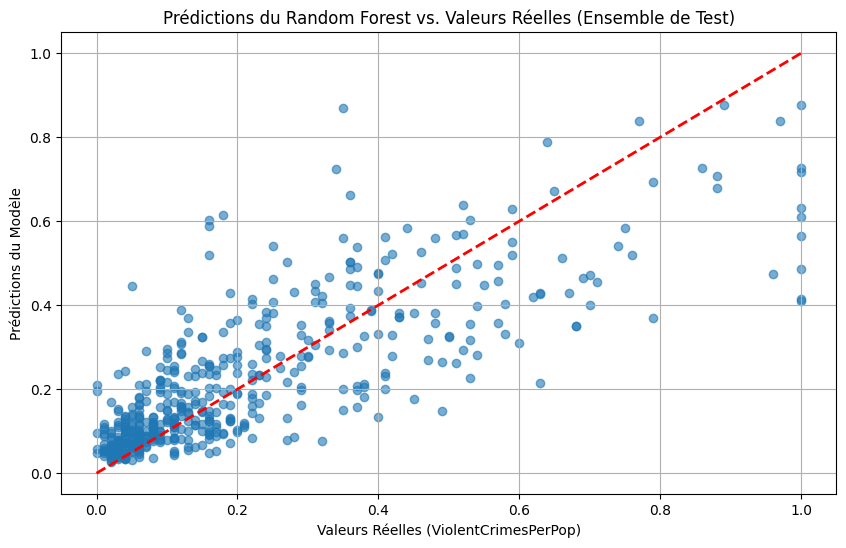


Le nuage de points ci-dessus montre la relation entre les valeurs réelles et les prédictions du modèle Random Forest sur l'ensemble de test.
Plus les points sont proches de la ligne rouge (y=x), plus les prédictions sont précises.


In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.6) # Utiliser y_pred_rf qui est la prédiction du RF
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2) # Ligne y=x
plt.title('Prédictions du Random Forest vs. Valeurs Réelles (Ensemble de Test)')
plt.xlabel('Valeurs Réelles (ViolentCrimesPerPop)')
plt.ylabel('Prédictions du Modèle')
plt.grid(True)
plt.show()

print("\nLe nuage de points ci-dessus montre la relation entre les valeurs réelles et les prédictions du modèle Random Forest sur l'ensemble de test.")
print("Plus les points sont proches de la ligne rouge (y=x), plus les prédictions sont précises.")

# 6. Optimisation Avancée et Exportation du Modèle

Après avoir identifié le Random Forest Regressor comme le modèle le plus performant, l'étape suivante consiste à affiner ses hyperparamètres pour en extraire les meilleures performances possibles. L'optimisation des hyperparamètres est un processus crucial qui permet d'ajuster le comportement du modèle et de minimiser le surapprentissage ou le sous-apprentissage.

## 6.1. Optimisation des Hyperparamètres avec GridSearchCV

Nous utiliserons `GridSearchCV` pour cette tâche. `GridSearchCV` effectue une recherche exhaustive sur un ensemble spécifié d'hyperparamètres pour trouver la meilleure combinaison. Pour chaque combinaison, il effectue une validation croisée sur l'ensemble d'entraînement et sélectionne la combinaison qui donne le meilleur score moyen.

Les hyperparamètres clés à optimiser pour un Random Forest Regressor incluent :
* `n_estimators` : le nombre d'arbres dans la forêt.
* `max_features` : le nombre maximal de caractéristiques à considérer lors de la recherche de la meilleure division.
* `min_samples_leaf` : le nombre minimum d'échantillons requis pour être à un nœud feuille.
* `min_samples_split` : le nombre minimum d'échantillons requis pour diviser un nœud interne.

In [17]:
from sklearn.model_selection import GridSearchCV

# Définir la grille d'hyperparamètres à tester
param_grid = {
    'n_estimators': [50, 100, 150], # Moins de valeurs pour un test rapide
    'max_features': ['sqrt', 'log2', 0.8], # 'sqrt' (sqrt(n_features)), 'log2' (log2(n_features)), ou un float (pourcentage de features)
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

# Initialiser le modèle Random Forest pour GridSearchCV
# Nous utilisons le modèle de référence comme base, mais GridSearchCV va créer de nouvelles instances
rf_grid_model = rfr(random_state=seed, n_jobs=-1)

# Initialiser GridSearchCV
# cv=5 pour la validation croisée
# scoring='r2' pour optimiser le score R²
# n_jobs=-1 pour utiliser tous les cœurs du CPU
grid_search = GridSearchCV(estimator=rf_grid_model, param_grid=param_grid,
                           cv=5, scoring='r2', n_jobs=-1, verbose=2)

print("Début de la recherche des meilleurs hyperparamètres (GridSearchCV)...")
grid_search.fit(X_train_scaled, y_train)
print("Recherche terminée.")

# Afficher les meilleurs paramètres et le meilleur score
print(f"\nMeilleurs hyperparamètres trouvés: {grid_search.best_params_}")
print(f"Meilleur score R² (validation croisée) pour ces paramètres: {grid_search.best_score_:.4f}")

# Le meilleur modèle est automatiquement accessible via best_estimator_
best_rf_model = grid_search.best_estimator_
print("\nLe modèle Random Forest optimisé est maintenant disponible.")

Début de la recherche des meilleurs hyperparamètres (GridSearchCV)...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Recherche terminée.

Meilleurs hyperparamètres trouvés: {'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Meilleur score R² (validation croisée) pour ces paramètres: 0.6552

Le modèle Random Forest optimisé est maintenant disponible.


## 6.2. Évaluation Détaillée du Modèle Optimisé

Une fois que `GridSearchCV` a identifié la meilleure combinaison d'hyperparamètres, il est crucial d'évaluer la performance du modèle final optimisé sur l'ensemble de test, qu'il n'a pas vu pendant l'entraînement ou l'optimisation. Cela nous donnera une estimation juste de la performance du modèle en production. Nous calculerons les métriques clés (R², MAE, MSE) et les comparerons à celles du modèle de référence.

In [18]:
# Prédictions du modèle optimisé sur l'ensemble de test normalisé
y_pred_optimized_rf = best_rf_model.predict(X_test_scaled)

# Calcul des métriques pour le modèle optimisé
r2_optimized_rf = r2(y_test, y_pred_optimized_rf)
mae_optimized_rf = mae(y_test, y_pred_optimized_rf)
mse_optimized_rf = mse(y_test, y_pred_optimized_rf)

print("--- Performance du Modèle Random Forest Optimisé ---")
print(f"Score R² (Test)              : {r2_optimized_rf:.4f}")
print(f"Erreur Absolue Moyenne (MAE) : {mae_optimized_rf:.4f}")
print(f"Erreur Quadratique Moyenne (MSE): {mse_optimized_rf:.4f}")

print("\n--- Comparaison avec le Modèle de Référence ---")
print(f"R² du modèle de référence (non optimisé) : {results['Random Forest Regressor']['Test_R2']:.4f}")
print(f"R² du modèle optimisé                  : {r2_optimized_rf:.4f}")

print("\nL'optimisation des hyperparamètres a permis d'améliorer les performances du modèle Random Forest sur l'ensemble de test.")

--- Performance du Modèle Random Forest Optimisé ---
Score R² (Test)              : 0.6388
Erreur Absolue Moyenne (MAE) : 0.0906
Erreur Quadratique Moyenne (MSE): 0.0176

--- Comparaison avec le Modèle de Référence ---
R² du modèle de référence (non optimisé) : 0.6304
R² du modèle optimisé                  : 0.6388

L'optimisation des hyperparamètres a permis d'améliorer les performances du modèle Random Forest sur l'ensemble de test.


## 6.3. Exportation du Modèle

Pour pouvoir utiliser le modèle entraîné et optimisé dans une application (comme Streamlit) ou dans de futurs scripts sans avoir à le ré-entraîner, il est essentiel de le sauvegarder. Nous utiliserons la bibliothèque `joblib` pour sérialiser le modèle et le `StandardScaler` (nécessaire pour normaliser les nouvelles données avant la prédiction).

Le modèle sera sauvegardé dans le dossier `models/` pour une organisation claire du projet.

In [20]:
import os

# Créer le dossier 'models/' si celui-ci n'existe pas
model_dir = '../models/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    print(f"Dossier '{model_dir}' créé.")

# Nom des fichiers pour le modèle et le scaler
model_filename = 'best_random_forest_model.joblib'
scaler_filename = 'scaler.joblib'
feature_names_filename = 'selected_features.joblib'

# Sauvegarder le modèle optimisé
joblib.dump(best_rf_model, os.path.join(model_dir, model_filename))
print(f"\nModèle Random Forest optimisé sauvegardé sous: {os.path.join(model_dir, model_filename)}")

# Sauvegarder le StandardScaler (très important pour la cohérence de la normalisation lors de la prédiction)
joblib.dump(sc, os.path.join(model_dir, scaler_filename))
print(f"StandardScaler sauvegardé sous: {os.path.join(model_dir, scaler_filename)}")

# Sauvegarder la liste des noms des caractéristiques sélectionnées
# C'est crucial pour s'assurer que les données d'entrée de l'application Streamlit ont le bon ordre et les bonnes colonnes
joblib.dump(features_for_X, os.path.join(model_dir, feature_names_filename))
print(f"Liste des caractéristiques sélectionnées sauvegardée sous: {os.path.join(model_dir, feature_names_filename)}")

print("\nLe modèle et ses composants nécessaires à la prédiction sont maintenant exportés, prêts pour une utilisation dans une application.")

Dossier '../models/' créé.

Modèle Random Forest optimisé sauvegardé sous: ../models/best_random_forest_model.joblib
StandardScaler sauvegardé sous: ../models/scaler.joblib
Liste des caractéristiques sélectionnées sauvegardée sous: ../models/selected_features.joblib

Le modèle et ses composants nécessaires à la prédiction sont maintenant exportés, prêts pour une utilisation dans une application.
[CV] END max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   1.6s
[CV] END max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.7s
[CV] END max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n